<a href="https://colab.research.google.com/github/BME6938-SPR2023/final_project/blob/main/SegProject_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies 

In [2]:
!pip install -q transformers datasets evaluate SimpleITK deepneuro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.7 MB/s eta 0:

### For Gloria: Login to HF

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
hf_username = "ashiyakatuka11"

### Importing Libraries

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#
import os as os
from glob import glob
import shutil
from tqdm import tqdm
import deepneuro
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import cv2
from torch.utils.data import Dataset
from skimage.transform import resize
import SimpleITK as sitk
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

## Data preprocessing

### Loading data from google drive

In [5]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection"

Text(0.5, 1.0, 'MASK')

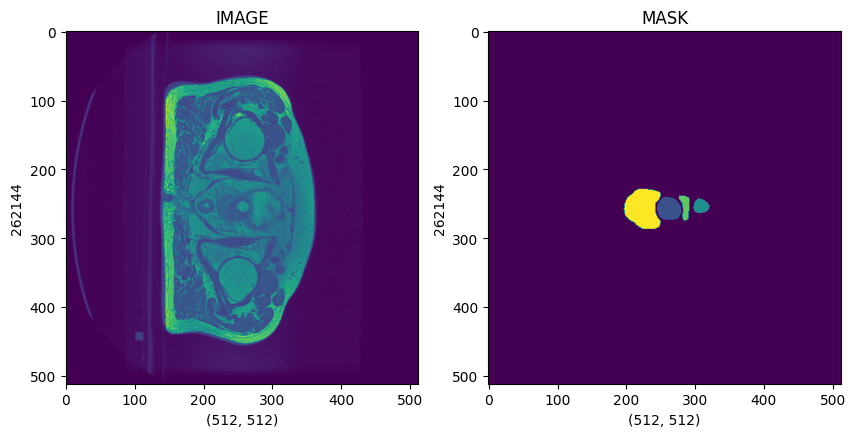

In [ ]:
#sample image/label
img_nifti = nib.load("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii")
img = img_nifti.get_fdata()
label_nifti = nib.load("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/labels/test/1_03_Z38.nii")
label = label_nifti.get_fdata()
#View image
# plt.imshow(img[:,:].T, cmap='Greys_r')
#example of image
figure,axis = plt.subplots(1,2,figsize=(10,10))
Plot_Color_Op = axis[0].imshow(img)
axis[0].set_xlabel(img.shape)
axis[0].set_ylabel(img.size)
axis[0].set_title("IMAGE")

axis[1].imshow(label)
axis[1].set_xlabel(label.shape)
axis[1].set_ylabel(label.size)
axis[1].set_title("MASK")

### Convert Nifti to Image (Not being used)

In [ ]:
## directory paths for all datasets
##train
tr_stacked_img_dir=folder_path + '/Stacked/train'
tr_t2_img_dir=folder_path + '/T2/train'
tr_dct_img_dir=folder_path + '/dCT/train'
tr_labels_dir=folder_path +'/labels/train'

##test
ts_stacked_img_dir=folder_path + '/Stacked/test'
ts_t2_img_dir=folder_path + '/T2/test'
ts_dct_img_dir=folder_path + '/dCT/test'
ts_labels_dir=folder_path +'/labels/test'

In [ ]:
tr_stacked_img_paths = sorted([os.path.join(tr_stacked_img_dir, x) for x in os.listdir(tr_stacked_img_dir)])
tr_t2_img_paths = sorted([os.path.join(tr_t2_img_dir, x) for x in os.listdir(tr_t2_img_dir)])
tr_dct_img_paths = sorted([os.path.join(tr_dct_img_dir, x) for x in os.listdir(tr_dct_img_dir)])
tr_labels_paths = sorted([os.path.join(tr_labels_dir, x) for x in os.listdir(tr_labels_dir)])

ts_stacked_img_paths = sorted([os.path.join(ts_stacked_img_dir, x) for x in os.listdir(ts_stacked_img_dir)])
ts_t2_img_paths = sorted([os.path.join(ts_t2_img_dir, x) for x in os.listdir(ts_t2_img_dir)])
ts_dct_img_paths = sorted([os.path.join(ts_dct_img_dir, x) for x in os.listdir(ts_dct_img_dir)])
ts_labels_paths = sorted([os.path.join(ts_labels_dir, x) for x in os.listdir(ts_labels_dir)])

In [ ]:
def img_label_dict(img_paths,labels_paths):
  img_list = []
  label_list = []
  # data_dict = {'pixel_values': [], 'label': []}
  for img,lbl in zip(img_paths,labels_paths):
      stacked_tr_img = sitk.ReadImage(img)
      tr_labels = sitk.ReadImage(lbl)
     # Convert to numpy arrays
      img_arr = sitk.GetArrayFromImage(stacked_tr_img).astype(np.float32)
      mask_arr = sitk.GetArrayFromImage(tr_labels).astype(np.float32)
    # Normalize the image to [0, 1]
      img_arr_norm = (img_arr- img_arr.min()) / (img_arr.max() - img_arr.min())
      #transpose image
      image= np.stack([img_arr_norm ] * 3, axis=-1).transpose((2,1,0))   

      img_list.append(image) 
      label_list.append(mask_arr) 
    
  data_dict =  {'pixel_values': img_list, 'label': label_list}
  return data_dict

In [ ]:
d_dict = img_label_dict(tr_stacked_img_paths,tr_labels_paths)
d_dict

{'pixel_values': [array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
  array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0

convert_nifti_to_image(tr_stacked_img_paths, tr_t2_img_paths,tr_dct_img_paths, tr_labels_paths, ts_stacked_img_paths,ts_t2_img_paths, ts_dct_img_paths, ts_labels_paths):

In [ ]:
def convert_nifti_to_image(tr_stacked_img_paths, tr_labels_paths, ts_stacked_img_paths, ts_labels_paths):
  train = {}
  test = {}
  img = {}
  labels = {}
  image_type = {}
  data_dict = {'train': [], 'test': []}
  
  train_test_list= []

  # Load NIfTI images using SimpleITK
  # stacked_tr_img = sitk.ReadImage(tr_stacked_img_paths)
  # t2_tr_img = sitk.ReadImage(tr_t2_img_paths)
  # dct_tr_img = sitk.ReadImage(tr_dct_img_paths)
  # tr_labels = sitk.ReadImage(tr_labels_paths)

  # stacked_ts_img = sitk.ReadImage(ts_stacked_img_paths)
  # t2_ts_img = sitk.ReadImage(ts_t2_img_paths)
  # dct_ts_img = sitk.ReadImage(ts_dct_img_paths)
  # ts_labels = sitk.ReadImage(ts_labels_paths)

  stacked_train = img_label_dict(tr_stacked_img_paths,tr_labels_paths)
  stacked_test = img_label_dict(ts_stacked_img_paths,ts_labels_paths)

  # data_dict = {'train': stacked_train , 'test': stacked_test}

  return data_dict
  

In [ ]:
data_dict = convert_nifti_to_image(tr_stacked_img_paths, tr_labels_paths, ts_stacked_img_paths, ts_labels_paths)

RuntimeError: ignored

In [239]:
img_path = "/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii"
mask_path = "/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/labels/test/1_03_Z38.nii"

In [240]:
 # Load NIfTI images using SimpleITK
img = sitk.ReadImage(img_path)
mask = sitk.ReadImage(mask_path)

In [241]:
img

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f8943c5b090> >

In [242]:
# Convert to numpy arrays
img_arr = sitk.GetArrayFromImage(img).astype(np.float32)
mask_arr = sitk.GetArrayFromImage(mask).astype(np.float32)

In [ ]:
# Normalize the image to [0, 1]
img_arr_norm = (img_arr- img_arr.min()) / (img_arr.max() - img_arr.min())

        # img_arr /= img_arr.max()

In [ ]:
image= np.stack([img_arr_norm ] * 3, axis=-1).transpose((2,1,0))


In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/segformer-b0-finetuned-ade-512-512")

/usr/local/lib/python3.9/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
from torch import nn

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=(512,512), # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]

In [ ]:
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())

for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
# img = np.array(image) * 0.5 + color_seg * 0.5
img = img_arr_norm.astype(np.uint8)

plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# Data preprocessing

In [ ]:
## directory paths for all datasets
##train
tr_stacked_img_dir=folder_path + '/Stacked/train'
tr_t2_img_dir=folder_path + '/T2/train'
tr_dct_img_dir=folder_path + '/dCT/train'
tr_labels_dir=folder_path +'/labels/train'

##test
ts_stacked_img_dir=folder_path + '/Stacked/test'
ts_t2_img_dir=folder_path + '/T2/test'
ts_dct_img_dir=folder_path + '/dCT/test'
ts_labels_dir=folder_path +'/labels/test'

In [ ]:
tr_stacked_img_paths = sorted([os.path.join(tr_stacked_img_dir, x) for x in os.listdir(tr_stacked_img_dir)])
tr_t2_img_paths = sorted([os.path.join(tr_t2_img_dir, x) for x in os.listdir(tr_t2_img_dir)])
tr_dct_img_paths = sorted([os.path.join(tr_dct_img_dir, x) for x in os.listdir(tr_dct_img_dir)])
tr_labels_paths = sorted([os.path.join(tr_labels_dir, x) for x in os.listdir(tr_labels_dir)])

ts_stacked_img_paths = sorted([os.path.join(ts_stacked_img_dir, x) for x in os.listdir(ts_stacked_img_dir)])
ts_t2_img_paths = sorted([os.path.join(ts_t2_img_dir, x) for x in os.listdir(ts_t2_img_dir)])
ts_dct_img_paths = sorted([os.path.join(ts_dct_img_dir, x) for x in os.listdir(ts_dct_img_dir)])
ts_labels_paths = sorted([os.path.join(ts_labels_dir, x) for x in os.listdir(ts_labels_dir)])

In [ ]:
def preprocess_data(img_paths, mask_paths): 
  img_list = []
  lbl_list = []
  tensor_list = []

  # data = {"pixel_values": [], "labels": []} 

  for i_img,i_mask in zip(img_paths,mask_paths):
    Reading_Img_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)

    img_arr = Reading_Img_NII.get_fdata()
    mask_arr = Reading_Label_NII.get_fdata()

      # Define the new size for the resized image
    new_size = (512, 512)
    
      # Resize the image using the resize() function from skimage
    img_resized = resize(img_arr, new_size, anti_aliasing=True)
    mask_resized = resize(mask_arr, new_size, anti_aliasing=True)

    # img_arr_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())
    img_arr_norm= np.stack([img_arr_norm ] * 3, axis=-1).transpose((2,1,0))

    # Convert to PyTorch tensors
    img_tensor = torch.from_numpy(img_arr_norm) 
    mask_tensor = torch.from_numpy(mask_resized) 

    
    img_list.append(img_tensor) #(3,512,512)
    lbl_list.append(mask_tensor.long()) #(512,512)

  data_dict= {"pixel_values": img_list, "labels": lbl_list} 
  return  data_dict

In [423]:
stacked_train = preprocess_data(tr_stacked_img_paths, tr_labels_paths)
t2_train = preprocess_data(tr_t2_img_paths, tr_labels_paths)
dct_train = preprocess_data(tr_dct_img_paths, tr_labels_paths)

stacked_test = preprocess_data(ts_stacked_img_paths, ts_labels_paths)
t2_test = preprocess_data(ts_t2_img_paths, ts_labels_paths)
dct_test = preprocess_data(ts_dct_img_paths, ts_labels_paths)

In [424]:
stacked_train_dataset = Dataset.from_dict(stacked_train)
t2_train_dataset = Dataset.from_dict(t2_train)
dct_train_dataset = Dataset.from_dict(dct_train)

stacked_test_dataset = Dataset.from_dict(stacked_test)
t2_test_dataset = Dataset.from_dict(t2_test)
dct_test_dataset = Dataset.from_dict(dct_test)
stacked_test_dataset

Dataset({
    features: ['pixel_values', 'labels'],
    num_rows: 4
})

In [425]:
stacked_train_dataset

Dataset({
    features: ['pixel_values', 'labels'],
    num_rows: 15
})

## Data Augementation (WIP)

In [336]:
 from deepneuro.augmentation.augment import Flip_Rotate_2D

In [417]:
def aug_data(img_paths, mask_paths ):
  img_list = []
  lbl_list = []
  tensor_list = []
  augment_img_data = []
  augment_label_data = []
  # Define the augmentation object
  augmentor = Flip_Rotate_2D(
        flip=True,
        rotation=True,
        shear=False,
        scale=False,
        elastic=False
    )

  # data = {"pixel_values": [], "labels": []} 

  for i_img,i_mask in zip(img_paths,mask_paths):
    Reading_Img_NII = nib.load(i_img)
    Reading_Label_NII = nib.load(i_mask)

    img_arr = Reading_Img_NII.get_fdata()
    mask_arr = Reading_Label_NII.get_fdata()

    # Define the new size for the resized image
    new_size = (512, 512)
    
    # Resize the image using the resize() function from skimage
    img_resized = resize(img_arr, new_size, anti_aliasing=True)
    mask_resized = resize(mask_arr, new_size, anti_aliasing=True)
    
    img_arr_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())
    img_arr_norm= np.stack([img_arr_norm ] * 3, axis=-1).transpose((2,1,0))

    augment_img_data.append(img_arr_norm )
    augment_label_data.append(mask_resized)

    img_tensor = torch.from_numpy(img_arr_norm)
    mask_tensor = torch.from_numpy(mask_resized)

    img_list.append(img_tensor) #(3,512,512)
    lbl_list.append(mask_tensor.long()) #(512,512)      

    ##Data augmentation
    # flip_augmentation = Flip_Rotate_2D(flip=True, 
    #                                rotate=True, 
    #                                data_groups=[img_arr_norm, mask_resized], 
    #                                flip_axis=2)

  # Augment the image ndarray
    # for i in range(10):
    # img_arr = img_arr_norm
    # lbl_arr = mask_resized

    # img_tensor1 = torch.tensor(augmentor.augment(img_arr_norm))
    img_list.append(torch.tensor(augmentor.augment(img_arr_norm)))

    # label_aug = augmentor.augment(mask_resized)
    # mask_tensor = torch.tensor(label_aug) 
    # lbl_list.append(mask_tensor.long())


    # augment_data.append_augmentation(flip_augmentation, multiplier=8)


  data_dict= {"pixel_values": img_list, "labels": lbl_list} 
  return  data_dict

In [420]:
# tr_aug_data_dict = aug_data(tr_stacked_img_paths, tr_labels_paths)
# ts_aug_data_dict = aug_data(ts_stacked_img_paths, ts_labels_paths)
# aug_data_dict

In [419]:
# aug_stacked_train_dataset = Dataset.from_dict(tr_aug_data_dict)
# aug_stacked_test_dataset = Dataset.from_dict(ts_aug_data_dict)

In [355]:
augment_img_data, augment_lbl_data = aug_data(tr_stacked_img_paths, tr_labels_paths)
len(augment_img_data)
augment_img_data[0].dtype

dtype('float64')

In [366]:
def aug_dataset(aug_imgs, aug_labels):
  img_list = []
  lbl_list = []
  for i_img,i_mask in zip(aug_imgs, aug_labels):
    # Convert to PyTorch tensors
    print(i_img.dtype)
    img_tensor = torch.tensor(i_img)
    mask_tensor = torch.tensor(i_mask )

  img_list.append(img_tensor) #(3,512,512)
  lbl_list.append(mask_tensor.long()) #(512,512)

  data_dict= {"pixel_values": img_list, "labels": lbl_list} 
  return data_dict

In [363]:
aug_img_arr, aug_lbl_arr = aug_data(tr_stacked_img_paths, tr_labels_paths)
aug_img_arr[0].dtype

dtype('float64')

In [382]:

def augg_dataset(aug_img_arr):
  img_list = []
  lbl_list = []
  for i in range(len(aug_img_arr)):
    img_tensor = torch.tensor(aug_img_arr[i])
    img_list.append(img_tensor)
    # mask_tensor = torch.tensor(aug_lbl_arr[i])
    # lbl_list.append(mask_tensor.long())
  # data_dict= {"pixel_values": img_list, "labels": lbl_list} 
  return img_list

In [307]:
import json
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "Cats-Can/image_data"

filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
# id2label = {0: 'None', 1: 'Prostate', 2: 'Rectum', 3: 'Seminal_vesicles', 4: 'Bladder'} #uncomment to use if having problems with HF
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

Id2label: {0: 'None', 1: 'Prostate', 2: 'Rectum', 3: 'Seminal_vesicles', 4: 'Bladder'}


# Finetuning SegFormer

In [308]:
# Load the segformer
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name, id2label=id2label,
    label2id=label2id)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'dec

In [439]:
from transformers import TrainingArguments

epochs = 20
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-pelvic"

training_args = TrainingArguments(
    "segformer-b0-finetuned-pelvic-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

In [436]:
import torch
from torch import nn
import evaluate
import multiprocessing
import warnings
warnings.filterwarnings('ignore')


metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,

        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [440]:
#train on stacked, test on stacked
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=stacked_train_dataset,
    eval_dataset=stacked_test_dataset,
    compute_metrics=compute_metrics,
)

/content/segformer-b0-finetuned-pelvic-outputs is already a clone of https://huggingface.co/ashiyakatuka11/segformer-b0-finetuned-pelvic. Make sure you pull the latest changes with `repo.git_pull()`.


In [441]:
trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy None,Accuracy Prostate,Accuracy Rectum,Accuracy Seminal Vesicles,Accuracy Bladder,Iou None,Iou Prostate,Iou Rectum,Iou Seminal Vesicles,Iou Bladder
20,0.016600,0.085681,0.051723,0.066960,0.119385,nan,0.000000,0.000000,0.000000,0.267841,0.000000,0.000000,0.000000,0.000000,0.258613
40,0.028000,0.067705,0.080421,0.107077,0.179176,nan,0.000000,0.052317,0.000000,0.375991,0.000000,0.000000,0.051914,0.000000,0.350190
60,0.010600,0.076739,0.061333,0.080461,0.135929,nan,0.005700,0.027267,0.000000,0.288877,0.000000,0.005687,0.027206,0.000000,0.273771
80,0.012300,0.081644,0.051770,0.067819,0.116342,nan,0.000000,0.020395,0.000000,0.250881,0.000000,0.000000,0.020390,0.000000,0.238459
100,0.015900,0.077220,0.065839,0.086716,0.148741,nan,0.000000,0.026158,0.000000,0.320705,0.000000,0.000000,0.026112,0.000000,0.303081
120,0.012000,0.085003,0.057383,0.076129,0.135732,nan,0.000000,0.000000,0.000000,0.304515,0.000000,0.000000,0.000000,0.000000,0.286915
140,0.011400,0.088452,0.047894,0.063243,0.112758,nan,0.000000,0.000000,0.000000,0.252974,0.000000,0.000000,0.000000,0.000000,0.239470
160,0.009300,0.085920,0.049306,0.065088,0.116047,nan,0.000000,0.000000,0.000000,0.260352,0.000000,0.000000,0.000000,0.000000,0.246532


TrainOutput(global_step=160, training_loss=0.013936429200111889, metrics={'train_runtime': 198.7736, 'train_samples_per_second': 1.509, 'train_steps_per_second': 0.805, 'total_flos': 5259478066790400.0, 'train_loss': 0.013936429200111889, 'epoch': 20.0})

In [450]:
# hub_model_id = "segformer-b0-finetuned-pelvic2"

training_args = TrainingArguments(
    "segformer-b0-finetuned-pelvic-outputs2",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    # push_to_hub=True,
    # hub_model_id=hub_model_id,
    # hub_strategy="end",
)

In [451]:
#train on stack, text on CT
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=stacked_train_dataset,
    eval_dataset=dct_test_dataset,
    compute_metrics=compute_metrics,
)


In [453]:
trainer.evaluate(dct_test_dataset)

{'eval_loss': 0.13590236008167267,
 'eval_mean_iou': 0.0,
 'eval_mean_accuracy': 0.0,
 'eval_overall_accuracy': 0.0,
 'eval_accuracy_None': nan,
 'eval_accuracy_Prostate': 0.0,
 'eval_accuracy_Rectum': 0.0,
 'eval_accuracy_Seminal_vesicles': 0.0,
 'eval_accuracy_Bladder': 0.0,
 'eval_iou_None': 0.0,
 'eval_iou_Prostate': 0.0,
 'eval_iou_Rectum': 0.0,
 'eval_iou_Seminal_vesicles': 0.0,
 'eval_iou_Bladder': 0.0,
 'eval_runtime': 2.305,
 'eval_samples_per_second': 1.735,
 'eval_steps_per_second': 0.868}

In [454]:
trainer.evaluate(t2_test_dataset)

{'eval_loss': 0.07609781622886658,
 'eval_mean_iou': 0.08066380283466057,
 'eval_mean_accuracy': 0.10527753621348501,
 'eval_overall_accuracy': 0.16960384860831573,
 'eval_accuracy_None': nan,
 'eval_accuracy_Prostate': 0.0,
 'eval_accuracy_Rectum': 0.08069164265129683,
 'eval_accuracy_Seminal_vesicles': 0.0,
 'eval_accuracy_Bladder': 0.3404185022026432,
 'eval_iou_None': 0.0,
 'eval_iou_Prostate': 0.0,
 'eval_iou_Rectum': 0.08022922636103152,
 'eval_iou_Seminal_vesicles': 0.0,
 'eval_iou_Bladder': 0.3230897878122713,
 'eval_runtime': 2.2825,
 'eval_samples_per_second': 1.752,
 'eval_steps_per_second': 0.876}

### New models

In [459]:
pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name, id2label=id2label,
    label2id=label2id)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'dec

In [473]:
hub_model_id = "segformer-b0-finetuned-pelvic4"

training_args2 = TrainingArguments(
    "segformer-b0-finetuned-pelvic-outputs4",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

In [474]:
#train on T2, text on T2
# from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=t2_train_dataset,
    eval_dataset=t2_test_dataset,
    compute_metrics=compute_metrics,
)


/content/segformer-b0-finetuned-pelvic-outputs4 is already a clone of https://huggingface.co/ashiyakatuka11/segformer-b0-finetuned-pelvic4. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

In [ ]:
#train on dCT, text on dCT
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args2,
    train_dataset=dct_train_dataset,
    eval_dataset=dct_test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

### Model predictions

In [315]:
predictions = trainer.predict(stacked_test_dataset)

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


In [316]:
predictions[1].shape

(4, 512, 512)

In [317]:
output = predictions[1]

In [318]:
class_predictions = np.argmax(output[:3], axis=0)
prediction_image = class_predictions.astype(np.uint8)

In [320]:
# prediction_image[1]

Text(0.5, 1.0, 'PREDICTION')

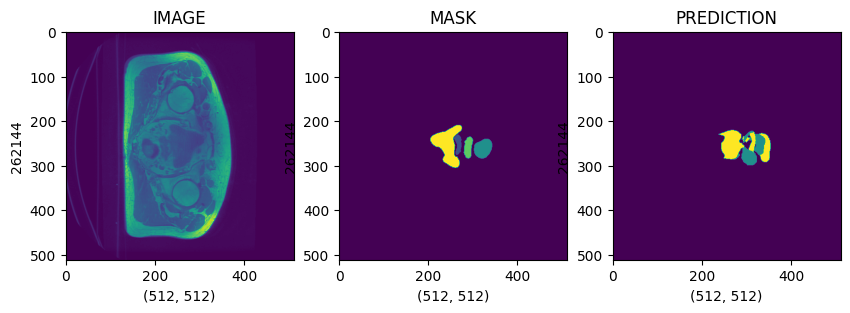

In [321]:
# figure = plt.subplots(1,figsize=(14,14))
img_number = 1
img_nifti = nib.load("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P3_02_Z36.nii")
img = img_nifti.get_fdata()
label_nifti = nib.load("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/labels/test/3_02_Z36.nii")
label = label_nifti.get_fdata()

Predict_Mask = prediction_image

figure,axis = plt.subplots(1,3,figsize=(10,10))
Plot_Color_Op = axis[0].imshow(img)
axis[0].set_xlabel(img.shape)
axis[0].set_ylabel(img.size)
axis[0].set_title("IMAGE")

axis[1].imshow(label)
axis[1].set_xlabel(label.shape)
axis[1].set_ylabel(label.size)
axis[1].set_title("MASK")
axis[2].imshow(Predict_Mask)
axis[2].set_xlabel(Predict_Mask.shape)
axis[2].set_ylabel(Predict_Mask.size)
axis[2].set_title("PREDICTION")

In [ ]:
from torch import nn

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

#DeepNeouro preprocessing


In [6]:
from deepneuro.load import load
img_nifti = nib.load("/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii")

In [26]:
from deepneuro.data import DataCollection

training_data_sources = {
    'directories': {
                '/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/':
                {'input_data': ['/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii'], 
                 'ground_truth': ['/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii']}},
}

In [27]:
training_data = DataCollection(data_sources=training_data_sources, verbose=True, slice_index=60)

('Gathering image data from...', {'/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/': {'input_data': ['/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii'], 'ground_truth': ['/content/drive/MyDrive/Colab Notebooks/datasets/GoldA_ZSliceSelection/Stacked/test/P1_03_Z38.nii']}}, '\n')
Found zero cases. Are you sure you have entered your data sources correctly?


##finetuning with Nifti images converted to PIL (Ignore)


In [9]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
import torch
from datasets import load_dataset
from PIL import Image
import requests

In [10]:
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.9/dist-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


## building a model (old ignore)

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def build_model():
    size = 256
    num_filters = [16, 32, 48, 64]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs
    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()
    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
model = build_model()

In [ ]:
opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

In [ ]:
train_steps = len(T2_train)//batch
if len(T2_train) % batch != 0:
    train_steps += 1

In [ ]:
model.fit(train_dataset1,
        # validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        # validation_steps=valid_steps
        # callbacks=callbacks
        )